In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import textblob
import gensim
import spacy
import os

import data
import plot

from chatty.utils import cleaning

/Users/ryan/miniconda3/envs/chatty/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/ryan/miniconda3/envs/chatty/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/Users/ryan/miniconda3/envs/chatty/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/ryan/miniconda3/envs/chatty/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


Takes a 5 minutes the first time, but use `use_cached` afterward so you don't have to wait in the future.

In [3]:
train, train_vecs, test, test_vecs = data.get_data(use_cached=True)

train['utter_len'] = train['utter'].map(lambda x: len(x.split(' ')))

train['has_question_mark'] = train['utter'].map(lambda x: 1 if'?' in x.split(' ') else 0)
train = pd.concat([train, data.get_lags(train[['has_question_mark']], lag_range=[1])], axis=1)

Using Cached


In [421]:
# LAG_MASK = ['act', 'emo', 'polarity', 'subjectivity']
# train_lags = data.get_lags(train[LAG_MASK], lag_range=[1, 2])

In [4]:
train['utter_t-1'] = data.get_lags(train[['utter']], lag_range=[1])

### Classify Dialogue Acts

### First shot Random forest, word vectors, handful of others (need to include POS stuff)

In [5]:
from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from chatty.utils import dd_encodings

/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### First shot with RandomForest

In [ ]:
ACT_MASK = train['act'].notnull() & train['has_question_mark_t-1'].notnull()

assert train['act'][train['act'].notnull()].shape[0] \
      == train_vecs[train['act'].notnull()].shape[0]

TRAIN_MASK = ['first_utterance',
              'subjectivity',
              'utter_len',
              'has_question_mark',
              'has_question_mark_t-1']

X = np.concatenate((train_vecs,
                    train[TRAIN_MASK].values),
                   axis=1)[ACT_MASK]
y = train['act'][ACT_MASK]

In [9]:
results = data.cv_stratified_shuffle(X, y,
                                     RandomForestClassifier(n_jobs=-1),
                                     splits=5,
                                     upsample='SMOTE')

Training
Training
Training
Training
Training


Normalized confusion matrix
[[0.49028102 0.13095635 0.34832833 0.0304343 ]
 [0.13614522 0.50461445 0.21951033 0.13973   ]
 [0.16993794 0.11067662 0.69890005 0.02048539]
 [0.02261995 0.10124669 0.0444371  0.83169626]]


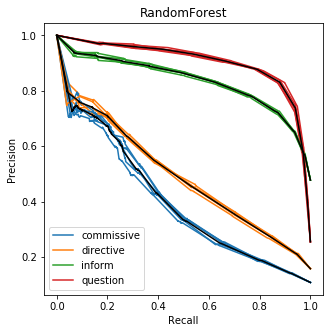

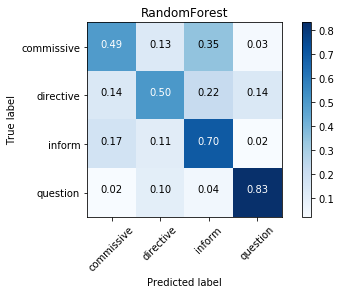

In [10]:
title = "RandomForest"
plot.plot_prec_rec(results, title)
le = LabelEncoder()
le.fit(results['classes'])
cm = confusion_matrix(le.transform(np.concatenate(results['y_true'])),
                      np.argmax(np.concatenate(results['y_proba']), axis=1))
plt.figure()
plot.plot_confusion_matrix(cm, le.classes_, normalize=True, title=title);

### Second Shot no word vectors

In [22]:
ACT_MASK = train['act'].notnull() & train['has_question_mark_t-1'].notnull()

assert train['act'][train['act'].notnull()].shape[0] \
      == train_vecs[train['act'].notnull()].shape[0]

TRAIN_MASK = ['first_utterance',
              'subjectivity',
              'utter_len',
              'has_question_mark',
              'has_question_mark_t-1']

# X = np.concatenate((train_vecs,
#                     train[TRAIN_MASK].values),
#                    axis=1)[ACT_MASK]
X = train[TRAIN_MASK].values[ACT_MASK]
y = train['act'][ACT_MASK]

In [27]:
results = data.cv_stratified_shuffle(X, y,
                                     RandomForestClassifier(n_jobs=-1),
                                     splits=5,
                                     upsample='SMOTE')

Training
Training
Training
Training
Training


Normalized confusion matrix
[[0.45784738 0.15583694 0.3497723  0.03654337]
 [0.16650141 0.28556174 0.27419724 0.27373961]
 [0.26918613 0.1610828  0.55297946 0.0167516 ]
 [0.01700038 0.07333774 0.01374197 0.89591991]]


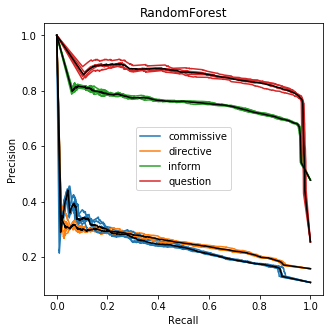

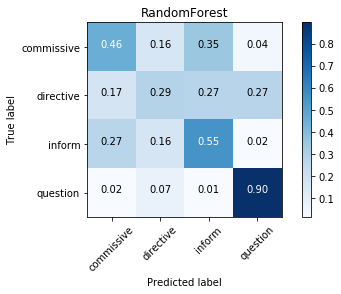

In [28]:
title = "RandomForest"
plot.plot_prec_rec(results, title)
le = LabelEncoder()
le.fit(results['classes'])
cm = confusion_matrix(le.transform(np.concatenate(results['y_true'])),
                      np.argmax(np.concatenate(results['y_proba']), axis=1))
plt.figure()
plot.plot_confusion_matrix(cm, le.classes_, normalize=True, title=title);

It looks like this classfier is really good at pointing out if something is a question or not. This could be used as a first line.

### Word vectors, Features, No Questions

In [55]:
ACT_MASK = train['act'].notnull() & train['has_question_mark_t-1'].notnull() & train['act'].isin(['directive', 'commissive', 'inform'])

assert train['act'][train['act'].notnull()].shape[0] \
      == train_vecs[train['act'].notnull()].shape[0]

TRAIN_MASK = ['first_utterance',
              'subjectivity',
              'utter_len',
              'has_question_mark',
              'has_question_mark_t-1']

X = np.concatenate((train_vecs,
                    train[TRAIN_MASK].values),
                   axis=1)[ACT_MASK]
y = train['act'][ACT_MASK]

In [56]:
results = data.cv_stratified_shuffle(X, y,
                                     RandomForestClassifier(n_jobs=-1),
                                     splits=5,
                                     upsample='SMOTE')

Training
Training
Training
Training
Training


Normalized confusion matrix
[[0.48750417 0.14650672 0.36598911]
 [0.12950957 0.64289528 0.22759515]
 [0.16448862 0.11874968 0.71676169]]


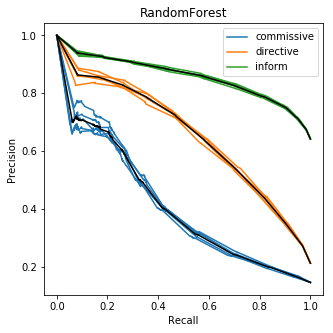

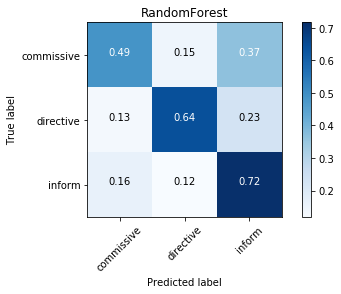

In [57]:
title = "RandomForest"
plot.plot_prec_rec(results, title)
le = LabelEncoder()
le.fit(results['classes'])
cm = confusion_matrix(le.transform(np.concatenate(results['y_true'])),
                      np.argmax(np.concatenate(results['y_proba']), axis=1))
plt.figure()
plot.plot_confusion_matrix(cm, le.classes_, normalize=True, title=title);

### Features, No Word vectors,  No Questions

In [58]:
ACT_MASK = train['act'].notnull() & train['has_question_mark_t-1'].notnull() & train['act'].isin(['directive', 'commissive', 'inform'])

assert train['act'][train['act'].notnull()].shape[0] \
      == train_vecs[train['act'].notnull()].shape[0]

TRAIN_MASK = ['first_utterance',
              'subjectivity',
              'utter_len',
              'has_question_mark',
              'has_question_mark_t-1']

# X = np.concatenate((train_vecs,
#                     train[TRAIN_MASK].values),
#                    axis=1)[ACT_MASK]
X = train[TRAIN_MASK].values[ACT_MASK]
y = train['act'][ACT_MASK]

In [59]:
results = data.cv_stratified_shuffle(X, y,
                                     RandomForestClassifier(n_jobs=-1),
                                     splits=5,
                                     upsample='SMOTE')

Training
Training
Training
Training
Training


Normalized confusion matrix
[[0.46273464 0.18005109 0.35721426]
 [0.18030661 0.53161467 0.28807871]
 [0.27115394 0.17447904 0.55436702]]


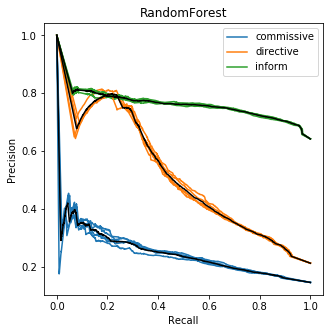

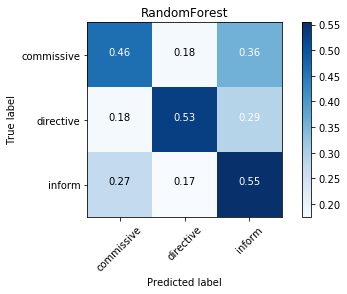

In [60]:
title = "RandomForest"
plot.plot_prec_rec(results, title)
le = LabelEncoder()
le.fit(results['classes'])
cm = confusion_matrix(le.transform(np.concatenate(results['y_true'])),
                      np.argmax(np.concatenate(results['y_proba']), axis=1))
plt.figure()
plot.plot_confusion_matrix(cm, le.classes_, normalize=True, title=title);

### POS, Lemma, Tagging

In [58]:
sample = train['utter'].tolist()[:10]

In [377]:
from sklearn.naive_bayes import BernoulliNB

In [394]:
import nltk
import spacy
from functools import partial
nlp = spacy.load('en')


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TransformerMixin
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.pipeline import Pipeline
import string


punctuations = string.punctuation


def filter_punct(word: spacy.tokens.token.Token) -> bool:
    return not word.is_punct


def filter_stop(word: spacy.tokens.token.Token) -> bool:
    return not word.is_stop


def lemmatize(word: spacy.tokens.token.Token) -> str:
    return word.lemma_


def part_of_speech(word: spacy.tokens.token.Token) -> str:
    return word.pos_


def tag(word: spacy.tokens.token.Token) -> str:
    return word.tag_


def original_word(word: spacy.tokens.token.Token) -> str:
    return word.text


def include_conditional_word(word: spacy.tokens.token.Token, word_list=[]) -> bool:
    if word.text.lower() in word_list:
        return word.text
    return ''


def join_ngrams(parsed_sentence: list, ngrams=[1], sep='|') -> list:
    for size in ngrams:
        for gram in nltk.ngrams(parsed_sentence, size):
            yield sep.join(gram)


def spacy_tokenizer(sentence: str, functions=[(original_word, 'original_word')], filters=[], include=[], ngrams=[1], prefix=''):
    sentence = sentence.strip()
    spacy_toks = nlp(sentence)
    tokens = []
    for tok in spacy_toks:
        includes = [f(tok) for f in include]
        if all([f(tok) for f in filters]) or any(includes):
            tags = [] + includes
            for f, f_name in functions:
                tags.append(f_name + '_' + f(tok))
            tokens.append('_'.join(tags))
    joined = join_ngrams(tokens, ngrams=ngrams)
    return joined

In [404]:
part_of_speech_grams = partial(spacy_tokenizer,
                               functions=[(part_of_speech, 'POS')],
                               filters=[filter_stop, filter_punct],
                               include=[partial(include_conditional_word, word_list=['?', '.'])],
                               ngrams=[2, 3])

part_of_speech_grams_t_minus_1 = partial(spacy_tokenizer,
                                         functions=[(lemmatize, 'lemma')],
                                         filters=[filter_stop, filter_punct],
                                         include=[partial(include_conditional_word, word_list=['?'])],
                                         ngrams=[1])

def analyzer(sent_pair):
    current, prev = sent_pair
    return list(part_of_speech_grams(current)) + list(part_of_speech_grams_t_minus_1(prev))

In [417]:
ACT_MASK = train['act'].notnull() & train['has_question_mark_t-1'].notnull()# & train['act'].isin(['directive', 'commissive', 'inform'])

assert train['act'][train['act'].notnull()].shape[0] \
      == train_vecs[train['act'].notnull()].shape[0]

TRAIN_MASK = ['first_utterance',
              'subjectivity',
              'utter_len',
              'has_question_mark',
              'has_question_mark_t-1']

# X = np.concatenate((train_vecs,
#                     train[TRAIN_MASK].values),
#                    axis=1)[ACT_MASK]
# X = train[TRAIN_MASK].values[ACT_MASK]
utterances = train['utter'][ACT_MASK].values
utterances_t_minus_1 = train['utter_t-1'][ACT_MASK].values
y = train['act'][ACT_MASK]

In [418]:
analyzer(next(zip(utterances, utterances_t_minus_1)))

['_POS_PRON|_POS_VERB',
 '_POS_VERB|_POS_VERB',
 '_POS_VERB|_POS_NOUN',
 '_POS_NOUN|._POS_PUNCT',
 '_POS_PRON|_POS_VERB|_POS_VERB',
 '_POS_VERB|_POS_VERB|_POS_NOUN',
 '_POS_VERB|_POS_NOUN|._POS_PUNCT',
 '_lemma_the',
 '_lemma_kitchen',
 '_lemma_stink']

In [419]:
clf = Pipeline([
    ('tfidf', CountVectorizer(analyzer=part_of_speech_grams)),
    ('naive_bayes', BernoulliNB())
])

results = data.cv_stratified_shuffle(utterances, y,
                                     clf,
#                                      RandomForestClassifier(n_jobs=-1),
                                     splits=5,
                                     upsample='SMOTE')

Training


ValueError: could not convert string to float: ' Thank you . '

Normalized confusion matrix
[[0.46273464 0.18005109 0.35721426]
 [0.18030661 0.53161467 0.28807871]
 [0.27115394 0.17447904 0.55436702]]


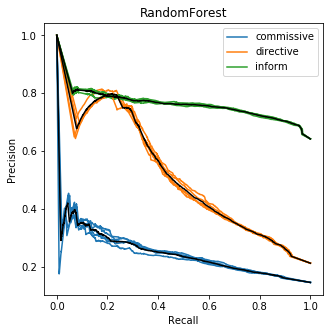

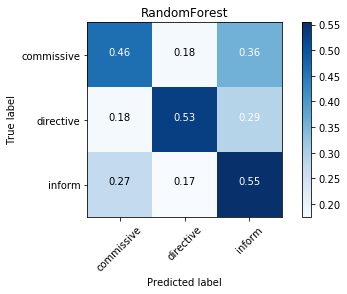

In [60]:
title = "RandomForest"
plot.plot_prec_rec(results, title)
le = LabelEncoder()
le.fit(results['classes'])
cm = confusion_matrix(le.transform(np.concatenate(results['y_true'])),
                      np.argmax(np.concatenate(results['y_proba']), axis=1))
plt.figure()
plot.plot_confusion_matrix(cm, le.classes_, normalize=True, title=title);

### Need to also include TFIDF and naive bayes

### Question marks are very important!

In [14]:
model = results['models'][0]

In [15]:
features = sorted(zip(model.feature_importances_, [str(i) for i in range(300)] + TRAIN_MASK), key=lambda x: x[0], reverse=True)

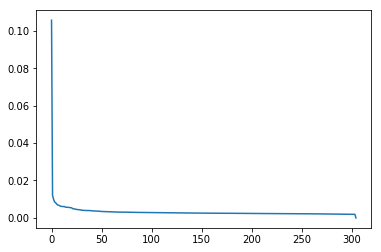

In [16]:
plt.plot(list(zip(*features))[0])

Commissive and Directives are being confused with inform. 

Given the strength of the question mark. 

I think our word vectors are doing very little to help us here. 

I think it's time to introduce some parts of speech tags along with n-grams to capture the use of commissive words and an "I" before them. 

### 20 and 21 are duplicates

In [17]:
def class_dist(col, df):
    nums = []
    for i in np.arange(0, 1, .1):
        nums.append(df[df[col] > i].shape[0] / df.shape[0])
    plt.plot(np.arange(0, 1, .1), nums, label=col)
    plt.legend()

def plot_confusion_contour(df):
    for cls in results['classes']:
        class_dist(cls, df)

def make_proba_df(results):
    y_proba = pd.DataFrame(np.concatenate(results['y_proba']))
    y_true = pd.concat(results['y_true'])
    y_proba.index = y_true.index
    y_proba.columns = results['classes']
    return y_proba

df = train.join(make_proba_df(results))

df = df[['utter', 'act'] + list(results['classes'])]

In [18]:
commissive = df[(df['act'] == 'commissive')]
commissive = commissive.sort_values('commissive', ascending=True)

In [19]:
num = 100
commissive.iloc[num]['utter']

' See you soon ! Bye ! Egg ... I can ’ t stand that woman or her obnoxious daughter . '

In [20]:
commissive.iloc[num]

utter          See you soon ! Bye ! Egg ... I can ’ t stand ...
act                                                  commissive
commissive                                                    0
directive                                                   0.1
inform                                                      0.7
question                                                    0.2
Name: (7634, 12), dtype: object

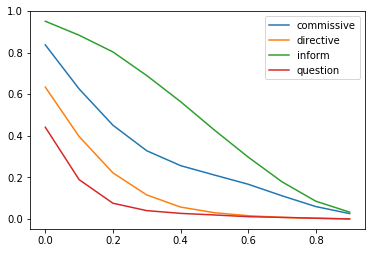

In [21]:
plot_confusion_contour(commissive)

### Start using spacy

In [28]:
import spacy
from spacy import displacy

nlp = spacy.load("en")

/Users/ryan/miniconda3/envs/chatty/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/ryan/miniconda3/envs/chatty/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [29]:
docs = [nlp(i) for i in commissive.iloc[100:110].sort_values('directive', ascending=False)['utter'].tolist()]

In [35]:
commissive.iloc[100:110]['utter'].tolist()[0]

' See you soon ! Bye ! Egg ... I can ’ t stand that woman or her obnoxious daughter . '

In [37]:
thing = nlp(commissive.iloc[100:110]['utter'].tolist()[0])

In [424]:
commissive.iloc[100:110].sort_values('directive', ascending=False)

,,utter,act,commissive,directive,inform,question
conv,,,,,,,
1849,1,"Yeah , Please do . Now let me show you the ho...",commissive,0.0,0.9,0.1,0.0
8556,26,Alright . I'll have another drink .,commissive,0.0,0.3,0.6,0.1
3405,8,Then you're not going to go to sleep .,commissive,0.0,0.3,0.2,0.5
1714,8,"Bill Black , Room 1201 .",commissive,0.0,0.2,0.8,0.0
8576,4,Sure ! Let ’ s have some nachos and mozzarell...,commissive,0.0,0.2,0.7,0.1
8566,7,Great ! Phew ! That was a close one ! You had...,commissive,0.0,0.2,0.8,0.0
8556,24,I thought a university was for studying .,commissive,0.0,0.2,0.8,0.0
3509,8,"That might be a little too much , but we ’ ll...",commissive,0.0,0.1,0.8,0.1
8928,1,"Dear , this bakery has introduced some new ty...",commissive,0.0,0.1,0.7,0.2


In [425]:
displacy.render(docs, style='dep', jupyter=True, options={'distance': 110})

In [372]:
spacy.explain('DET')

'determiner'

# Trying spacy

In [44]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TransformerMixin
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.pipeline import Pipeline
import string

punctuations = string.punctuation

def spacy_tokenizer(sentence):
    tokens = nlp(sentence)
    tokens = [tok for tok in tokens
              if (tok.lemma_.lower().strip() not in punctuations \
                  or tok.lemma_.lower().strip() not in stopwords)]
    tokens = [tok.lemma_.lower().strip() +
#                "_DEP_" + tok.dep_ + "_POS_" + tok.pos_
                "_DEP_" + tok.dep_
              if tok.lemma_ != "-PRON-" else tok.lower_ 
              for tok in tokens]
    return tokens

#Custom transformer using spaCy 
class Cleaner(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

# Basic utility function to clean the text 
def clean_text(text):     
    if text is None or text is np.nan:
        return ''
    return text.strip().lower()

In [41]:
pipe = Pipeline([("cleaner", Cleaner()),
                 ('vectorizer', CountVectorizer(tokenizer=spacy_tokenizer)),
                 ('RF', RandomForestClassifier(n_jobs=-1))])

# Only using text

In [58]:
vec = CountVectorizer(tokenizer=spacy_tokenizer)
utter_vecs = vec.fit_transform(train['utter'])

# Didn't work

### Try Bayes with TFIDF (also include POS)

In [208]:
from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import BernoulliNB

from chatty.utils import dd_encodings

ACT_MASK = train['act'].notnull() & train['has_question_mark_t-1'].notnull()

assert train['act'][train['act'].notnull()].shape[0] \
      == train_vecs[train['act'].notnull()].shape[0]

TRAIN_MASK = ['first_utterance',
              'subjectivity',
              'utter_len',
              'has_question_mark',
              'has_question_mark_t-1']

X = np.concatenate((train_vecs,
                    train[TRAIN_MASK].values),
                   axis=1)[ACT_MASK]
y = train['act'][ACT_MASK]

In [209]:
results = data.cv_stratified_shuffle(X, y,
                                     BernoulliNB(),
                                     splits=5)

Training
Training
Training
Training
Training


Normalized confusion matrix
[[0.32078196 0.29223592 0.33644341 0.05053871]
 [0.06117001 0.62748837 0.18587446 0.12546716]
 [0.16857561 0.22105051 0.56614865 0.04422524]
 [0.03962032 0.18398187 0.11144692 0.66495089]]


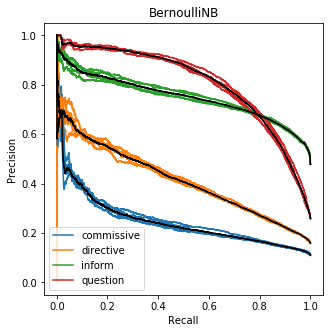

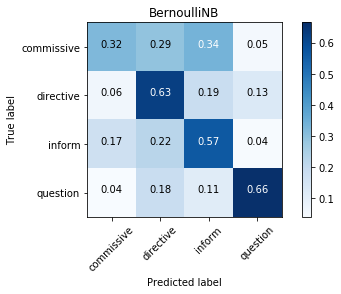

In [210]:
title = "BernoulliNB"
plot.plot_prec_rec(results, title)
le = LabelEncoder()
le.fit(results['classes'])
cm = confusion_matrix(le.transform(np.concatenate(results['y_true'])),
                      np.argmax(np.concatenate(results['y_proba']), axis=1))
plt.figure()
plot.plot_confusion_matrix(cm, le.classes_, normalize=True, title=title);